### Домашнее задание №7.

***1. Взять любой набор данных для бинарной классификации.***

***2. Сделать обзорный анализ выбранного датасета.***

***3. Обучить любой классификатор (какой вам нравится)***

***4. Разобраться с SHAP и построить важности признаков для: 
   a) всего тестового набора данных (summary_plot - дать интерпретацию) 
   б) для 5 случайных объектов из тестового набора.***

In [1]:
# Загрузим необходимые библиотеки:
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score
from catboost import CatBoostClassifier

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
shap.initjs()
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

***Возьмем датасет, который содержит 70 000 наблюдений за пациентами с кардиологическими заболеваниями. На основе этих наблюдений обучим модель, сделаем предсказания и попробуем с помощью библиотеки SHAP объяснить полученный результат и какие факторы на него наиболее всего повлияли.***

In [5]:
df = pd.read_csv('./cardio_case.csv', ';')
df.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


***Мы видим, что датасет содержит такие данные как возраст, пол, рост, вес, величину верхнего и нижнего артериального давления, холестерин, сахар крови, а так же данные о вредных привычках (курение, алкоголь) и об активности пациентов.***

***Посмотрим на количество данных в датасете***

In [6]:
df.shape

(70000, 13)

***Проверим датасет на пропуски и на тип данных (для корректной работы модели):***

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


***Посмотрим на соотношение классов:***

In [8]:
df['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

***Разобъем выборку на тренировочную и тестовую и обучим модель. 
Возьмем модель градиентного бустинга CatBoostClassifier.***

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='cardio'), df['cardio'], random_state=0)

In [10]:
X_train.shape, X_test.shape

((52500, 12), (17500, 12))

***Обучим модель и сделаем предсказания:***

In [11]:
%%time
model = CatBoostClassifier(verbose=False)

model.fit(X_train, y_train)
cat_predict = model.predict(X_test)

Wall time: 27.8 s


***С помощью библиотеки SHAP визуализируем на графике важнось признаков для всего тестового набора данных.***

In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

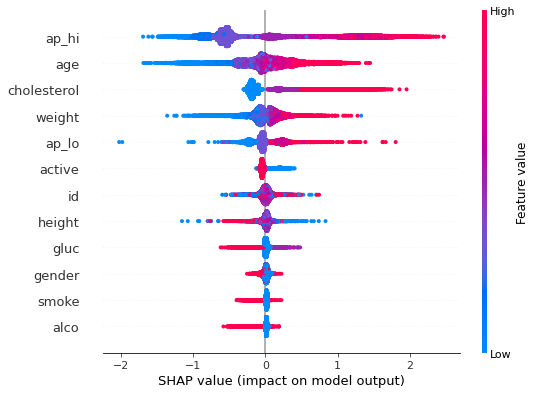

In [13]:
shap.summary_plot(shap_values, X_test)

***Вполне ожидаемо повышенное артериальное давление,большой возраст, повышенное содержание холестерина в крови, а так же излишний вес очень сильно повышают вероятность инфаркта. Низкая активность тоже силно увеличивает этот риск. Но что совершенно для меня неожиданно: чрезмерное увлечение алкоголем и курением наоборот - служит фактором, снижающим риск сердечных заболеваний!***

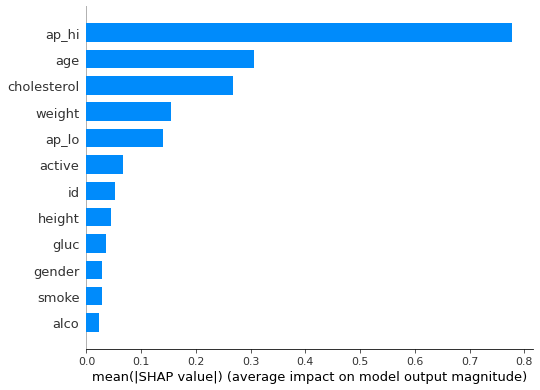

In [14]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

***Посмотрим как различные факторы влияют несколько случайно выбранных пациентов:***

In [15]:
idx = 2
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:])

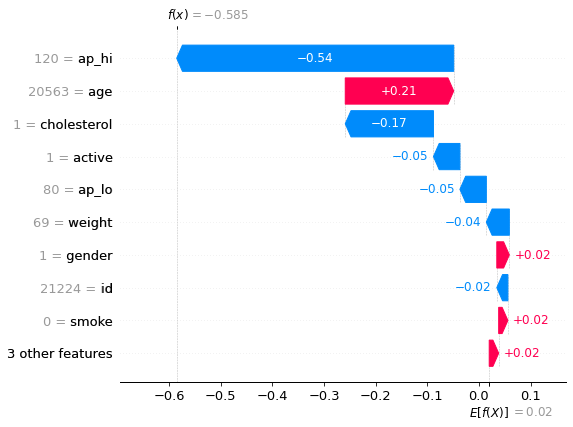

In [16]:
shap_values_one = explainer(X_test.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

***У пациента с индексом 2 прогноз очень хороший: его давление 120х80, нормальное содержание холестерина, физическая активность и вес 69 кг служат факторами, снижающими риск заболевания, не смотря на то, что унего уже большой возраст.*** 

In [17]:
idx = 9
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:])

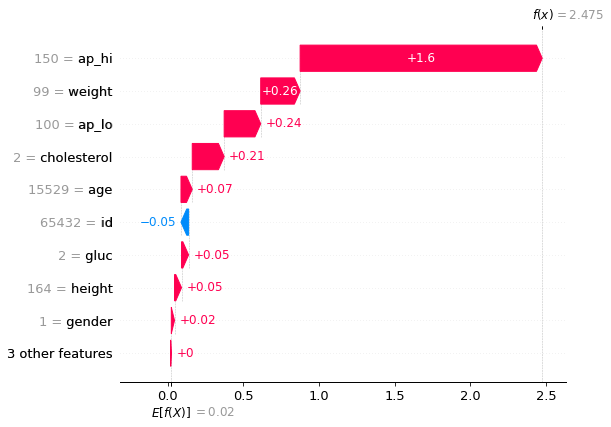

In [18]:
shap_values_one = explainer(X_test.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

***Совсем иная картина в этом случае: факторы, уменьшающие риск (id не считается), отсутствуют. Пациенту надо быть предельно осторожным и позаболтиться о завещании.***

In [19]:
idx = 100
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:])

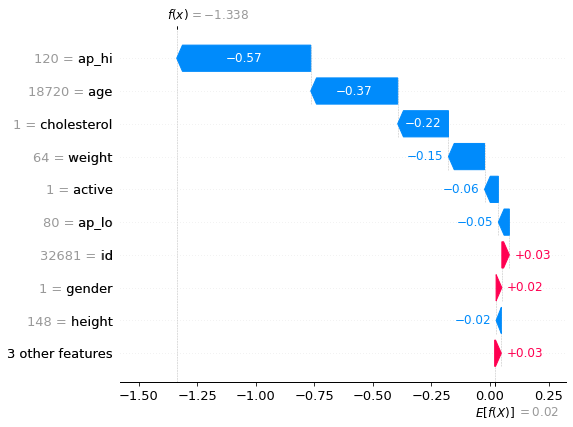

In [20]:
shap_values_one = explainer(X_test.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

In [21]:
idx = 150
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:])

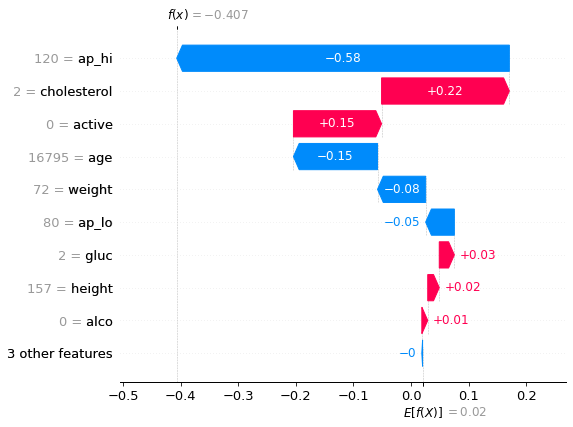

In [22]:
shap_values_one = explainer(X_test.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

In [23]:
idx = 200
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:])

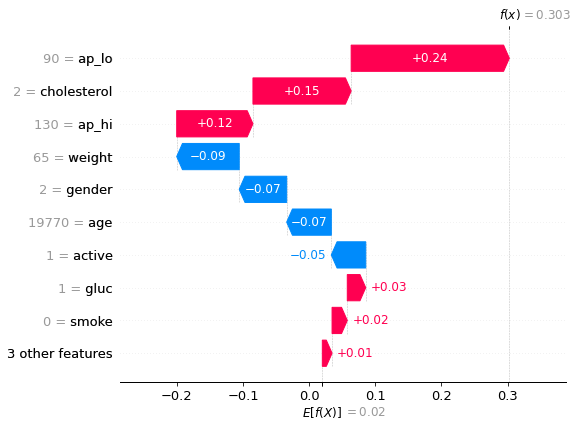

In [24]:
shap_values_one = explainer(X_test.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

***В данном случае отрицательное воздействие на организм повышенного давления, повышенного содержания холестерина и сахара в крови, а так же вред от курения перевешивают влияние таких положительных факторов как:нормальный вес, молодой возраст и физическая активность. Общий индекс 0.303 значительно выше базового значения 0.019.***

**ВЫВОД: библиотека SHAP является очень полезным инструментом, позволяющим визуализировать и интерпретировать полученные данные, что позволит наглядно показать заказчику работу модели и алгоритм принятия ей решений.**

***Ещё один инструмент - тепловая карта позволяет наглядно посмотреть расрпеделение влияния разных признаков на решение модели.***

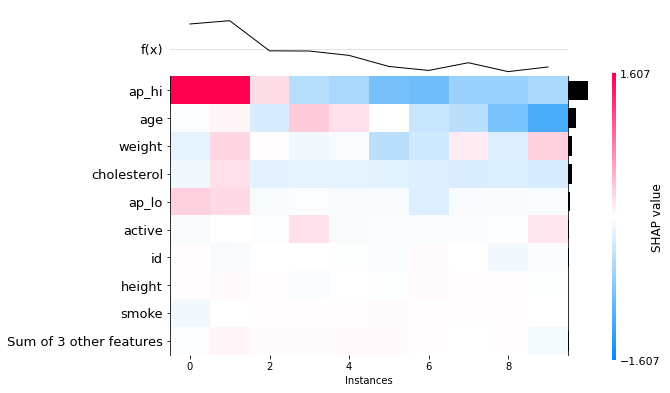

In [25]:
n = 10
shap_values = explainer(X_test.iloc[:n])
shap.plots.heatmap(shap_values)

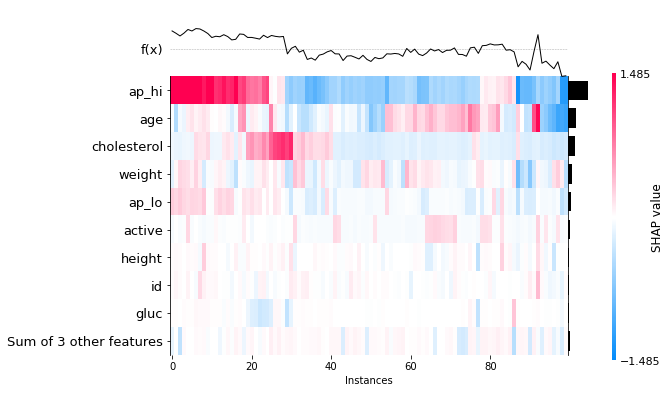

In [26]:
n = 100
shap_values = explainer(X_test.iloc[:n])
shap.plots.heatmap(shap_values)